In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings

In [4]:
warnings.filterwarnings('ignore')

# --- I. Công Cụ Sử Dụng ---
# Các thư viện đã được import ở trên.

# --- II. Phương Pháp Phân Tích ---

In [5]:
df = pd.read_csv('Train.csv')

In [6]:
# Sắp xếp theo ngày tháng ngay từ đầu
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True) # Reset index sau khi sắp xếp

print("\nThông tin ban đầu về dữ liệu (đã sắp xếp theo ngày):")
df.info()


Thông tin ban đầu về dữ liệu (đã sắp xếp theo ngày):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18483 entries, 0 to 18482
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  18483 non-null  object 
 1   Category              18483 non-null  object 
 2   Brand                 18483 non-null  object 
 3   Day_of_Week           18483 non-null  int64  
 4   Holiday_Indicator     18483 non-null  int64  
 5   Past_Purchase_Trends  18483 non-null  float64
 6   Price                 18483 non-null  float64
 7   Discount              18483 non-null  float64
 8   Competitor_Price      18483 non-null  float64
 9   Sales_Quantity        18019 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.4+ MB


In [7]:
# Kiểm tra và xử lý giá trị thiếu
print(df.isnull().sum())

Date                      0
Category                  0
Brand                     0
Day_of_Week               0
Holiday_Indicator         0
Past_Purchase_Trends      0
Price                     0
Discount                  0
Competitor_Price          0
Sales_Quantity          464
dtype: int64


In [8]:
# Điền giá trị thiếu cho các cột số (trừ Sales_Quantity sẽ xử lý sau)
# Ví dụ: Điền bằng giá trị trung bình (mean) hoặc trung vị (median)
numeric_cols_to_impute = ['Past_Purchase_Trends', 'Price', 'Discount', 'Competitor_Price']
for col in numeric_cols_to_impute:
    if df[col].isnull().any():
        median_val = df[col].median() # Sử dụng median để ít bị ảnh hưởng bởi ngoại lệ
        df[col].fillna(median_val, inplace=True)
        print(f"Đã điền giá trị thiếu cho cột '{col}' bằng median ({median_val:.2f}).")

In [9]:
# Loại bỏ các hàng thiếu giá trị 'Sales_Quantity' (biến mục tiêu)
initial_rows = len(df)
df.dropna(subset=['Sales_Quantity'], inplace=True)
final_rows = len(df)
print(f"\nĐã loại bỏ {initial_rows - final_rows} hàng thiếu giá trị 'Sales_Quantity'.")
df['Sales_Quantity'] = pd.to_numeric(df['Sales_Quantity']) # Đảm bảo là số


Đã loại bỏ 464 hàng thiếu giá trị 'Sales_Quantity'.


In [10]:
# Kiểm tra lại giá trị thiếu
print("\nKiểm tra lại giá trị thiếu sau khi xử lý:")
print(df.isnull().sum())


Kiểm tra lại giá trị thiếu sau khi xử lý:
Date                    0
Category                0
Brand                   0
Day_of_Week             0
Holiday_Indicator       0
Past_Purchase_Trends    0
Price                   0
Discount                0
Competitor_Price        0
Sales_Quantity          0
dtype: int64


# --- III. Xây dựng mô hình dự đoán ---

In [12]:
# 1. Mô hình Prophet để nắm bắt xu hướng và mùa vụ
print("\n--- 1. Huấn luyện mô hình Prophet ---")
# Chuẩn bị dữ liệu cho Prophet
df_prophet = df[['Date', 'Sales_Quantity']].copy()
df_prophet.rename(columns={'Date': 'ds', 'Sales_Quantity': 'y'}, inplace=True)


--- 1. Huấn luyện mô hình Prophet ---


# Xác định các biến ngoại sinh (regressors) cho Prophet
# Sử dụng các biến số có thể ảnh hưởng đến xu hướng cơ bản hoặc mùa vụ
# Lưu ý: Prophet xử lý tốt nhất với các regressors có sẵn giá trị trong tương lai nếu bạn muốn dự báo xa.
# Ở đây, ta dùng các giá trị hiện tại làm regressors để nắm bắt ảnh hưởng của chúng.

In [13]:
regressors = ['Price', 'Discount', 'Competitor_Price', 'Holiday_Indicator', 'Past_Purchase_Trends']
df_prophet[regressors] = df[regressors]

In [14]:
# Chia dữ liệu cho Prophet (train/test theo thời gian)
prophet_split_index = int(len(df_prophet) * 0.8)
df_prophet_train = df_prophet.iloc[:prophet_split_index]
df_prophet_test = df_prophet.iloc[prophet_split_index:] # Dùng để tham khảo, nhưng dự đoán trên toàn bộ df

In [15]:
# Khởi tạo và huấn luyện mô hình Prophet
# yearly_seasonality, weekly_seasonality, daily_seasonality có thể được bật/tắt hoặc tùy chỉnh
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

In [16]:
# Thêm regressors
for regressor in regressors:
    prophet_model.add_regressor(regressor)

print("Huấn luyện Prophet...")
prophet_model.fit(df_prophet_train)
print("Huấn luyện Prophet hoàn thành.")

Huấn luyện Prophet...


10:07:16 - cmdstanpy - INFO - Chain [1] start processing
10:07:17 - cmdstanpy - INFO - Chain [1] done processing


Huấn luyện Prophet hoàn thành.


In [17]:
# Tạo dataframe chứa toàn bộ thời gian (quá khứ + tương lai nếu có) để dự đoán
# Ở đây ta dự đoán trên toàn bộ dữ liệu đã có để lấy các thành phần làm feature
print("Tạo dự đoán từ Prophet...")
forecast = prophet_model.predict(df_prophet)
print("Dự đoán Prophet hoàn thành.")

Tạo dự đoán từ Prophet...
Dự đoán Prophet hoàn thành.


In [18]:
# Lấy các thành phần dự đoán từ Prophet để làm feature cho LightGBM
df['prophet_yhat'] = forecast['yhat']
df['prophet_trend'] = forecast['trend']
df['prophet_yearly'] = forecast['yearly']
df['prophet_weekly'] = forecast['weekly']


# 2. Tiền xử lý Dữ liệu cho LightGBM (Kết hợp đặc trưng Prophet)

In [43]:
print(df_lgbm['Date'].dtype)

object


In [44]:
df_lgbm['Date'] = pd.to_datetime(df_lgbm['Date'], errors='coerce')

In [45]:
print(df_lgbm['Date'].head())

0   2022-01-02
1   2022-01-02
2   2022-01-02
3   2022-01-02
4   2022-01-02
Name: Date, dtype: datetime64[ns]


In [46]:

# Tạo đặc trưng thời gian
df_lgbm['Year'] = df_lgbm['Date'].dt.year
df_lgbm['Month'] = df_lgbm['Date'].dt.month
df_lgbm['Day'] = df_lgbm['Date'].dt.day
df_lgbm['DayOfWeek'] = df_lgbm['Date'].dt.dayofweek # Giữ lại Day_of_Week gốc nếu muốn
df_lgbm['DayOfYear'] = df_lgbm['Date'].dt.dayofyear
df_lgbm['WeekOfYear'] = df_lgbm['Date'].dt.isocalendar().week.astype(int)
df_lgbm['Quarter'] = df_lgbm['Date'].dt.quarter


print("Đã tạo thêm các đặc trưng thời gian.")

Đã tạo thêm các đặc trưng thời gian.


# Mã hóa biến phân loại
# LightGBM có thể xử lý trực tiếp biến kiểu category, nhưng one-hot đôi khi vẫn hiệu quả

Label Encoding (thay thế bằng số nguyên) - Cần báo cho LGBM biết đây là categorical

In [47]:
label_encoders = {}
categorical_cols = ['Category', 'Brand']
for col in categorical_cols:
    le = LabelEncoder()
    df_lgbm[col] = le.fit_transform(df_lgbm[col])
    label_encoders[col] = le # Lưu lại để có thể biến đổi ngược nếu cần
    df_lgbm[col] = df_lgbm[col].astype('category') # Chuyển sang kiểu category cho LGBM
print("Đã mã hóa Label Encoding và chuyển sang kiểu 'category' cho Category và Brand.")

Đã mã hóa Label Encoding và chuyển sang kiểu 'category' cho Category và Brand.


# --- Chuẩn bị dữ liệu cho LightGBM ---

In [48]:
features_to_drop = ['Sales_Quantity', 'Date'] # Bỏ cột mục tiêu và cột ngày gốc
X = df_lgbm.drop(columns=features_to_drop)
y = df_lgbm['Sales_Quantity']

# Đảm bảo tất cả các cột trong X đều là số hoặc category
print("\nCác biến độc lập (Features) được chọn cho LightGBM:")
print(X.columns.tolist())
print("\nKiểu dữ liệu của các features:")
print(X.dtypes)


Các biến độc lập (Features) được chọn cho LightGBM:
['Category', 'Brand', 'Day_of_Week', 'Holiday_Indicator', 'Past_Purchase_Trends', 'Price', 'Discount', 'Competitor_Price', 'prophet_yhat', 'prophet_trend', 'prophet_yearly', 'prophet_weekly', 'Year', 'Month', 'Day', 'DayOfWeek', 'DayOfYear', 'WeekOfYear', 'Quarter']

Kiểu dữ liệu của các features:
Category                category
Brand                   category
Day_of_Week                int64
Holiday_Indicator          int64
Past_Purchase_Trends     float64
Price                    float64
Discount                 float64
Competitor_Price         float64
prophet_yhat             float64
prophet_trend            float64
prophet_yearly           float64
prophet_weekly           float64
Year                       int32
Month                      int32
Day                        int32
DayOfWeek                  int32
DayOfYear                  int32
WeekOfYear                 int64
Quarter                    int32
dtype: object


In [49]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo thời gian (80/20)
split_index = int(len(X) * 0.8)
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

print(f"\nKích thước tập huấn luyện (Train): {X_train.shape[0]} mẫu")
print(f"Kích thước tập kiểm tra (Test): {X_test.shape[0]} mẫu")



Kích thước tập huấn luyện (Train): 14415 mẫu
Kích thước tập kiểm tra (Test): 3604 mẫu


# --- Huấn luyện Mô hình LightGBM ---

In [50]:
# Khai báo tham số cho LightGBM (có thể tinh chỉnh thêm)
params = {
    'objective': 'regression_l1', # MAE loss - thường robust hơn với outlier so với MSE ('regression' or 'regression_l2')
    'metric': 'mae',
    'n_estimators': 1000,         # Số lượng cây (có thể tăng lên và dùng early stopping)
    'learning_rate': 0.05,
    'feature_fraction': 0.8,      # Chọn ngẫu nhiên % features cho mỗi cây
    'bagging_fraction': 0.8,      # Chọn ngẫu nhiên % data cho mỗi cây
    'bagging_freq': 1,
    'lambda_l1': 0.1,             # L1 regularization
    'lambda_l2': 0.1,             # L2 regularization
    'num_leaves': 31,             # Số lá tối đa trong 1 cây
    'verbose': -1,                # Tắt bớt log khi huấn luyện
    'n_jobs': -1,                 # Sử dụng tất cả CPU cores
    'seed': 42,
    'boosting_type': 'gbdt',
}

In [51]:
# Chỉ định rõ các cột categorical cho LGBM nếu dùng Label Encoding
categorical_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols if col in X_train.columns]

print("Huấn luyện LightGBM...")
lgbm_model = lgb.LGBMRegressor(**params)

Huấn luyện LightGBM...


# Sử dụng early stopping để tránh overfitting và tìm số cây tối ưu
# Cần có tập validation để dùng early stopping hiệu quả, ở đây tạm huấn luyện trên toàn bộ train set
# Để dùng early stopping: chia tập train thành train_sub và validation_sub
# lgbm_model.fit(X_train, y_train,
#                eval_set=[(X_test, y_test)], # Hoặc dùng tập validation riêng
#                eval_metric='mae',
#                callbacks=[lgb.early_stopping(100, verbose=True)],
#                categorical_feature=categorical_features_indices) # Nếu dùng Label Encoding

In [52]:
# Huấn luyện không có early stopping (như code gốc)
lgbm_model.fit(X_train, y_train, categorical_feature=categorical_features_indices)
print("Huấn luyện LightGBM hoàn thành.")


Huấn luyện LightGBM hoàn thành.


# --- Dự đoán ---

In [53]:
print("\n--- Thực hiện dự đoán với LightGBM ---")
y_pred_train_lgbm = lgbm_model.predict(X_train)
y_pred_test_lgbm = lgbm_model.predict(X_test)
print("Đã dự đoán trên tập huấn luyện và tập kiểm tra.")


--- Thực hiện dự đoán với LightGBM ---
Đã dự đoán trên tập huấn luyện và tập kiểm tra.


# --- Đánh giá Mô hình LightGBM ---

In [54]:
# Đánh giá trên tập huấn luyện
mse_train_lgbm = mean_squared_error(y_train, y_pred_train_lgbm)
mae_train_lgbm = mean_absolute_error(y_train, y_pred_train_lgbm)
r2_train_lgbm = r2_score(y_train, y_pred_train_lgbm)
print("Kết quả trên tập Huấn luyện (LGBM):")
print(f"  Mean Squared Error (MSE): {mse_train_lgbm:.2f}")
print(f"  Mean Absolute Error (MAE): {mae_train_lgbm:.2f}")
print(f"  R-squared (R²): {r2_train_lgbm:.2f}")

Kết quả trên tập Huấn luyện (LGBM):
  Mean Squared Error (MSE): 10633.86
  Mean Absolute Error (MAE): 78.64
  R-squared (R²): 0.47


In [55]:
# Đánh giá trên tập kiểm tra
mse_test_lgbm = mean_squared_error(y_test, y_pred_test_lgbm)
mae_test_lgbm = mean_absolute_error(y_test, y_pred_test_lgbm)
r2_test_lgbm = r2_score(y_test, y_pred_test_lgbm)
print("\nKết quả trên tập Kiểm tra (LGBM):")
print(f"  Mean Squared Error (MSE): {mse_test_lgbm:.2f}")
print(f"  Mean Absolute Error (MAE): {mae_test_lgbm:.2f}")
print(f"  R-squared (R²): {r2_test_lgbm:.2f}")



Kết quả trên tập Kiểm tra (LGBM):
  Mean Squared Error (MSE): 21542.25
  Mean Absolute Error (MAE): 124.89
  R-squared (R²): -0.09


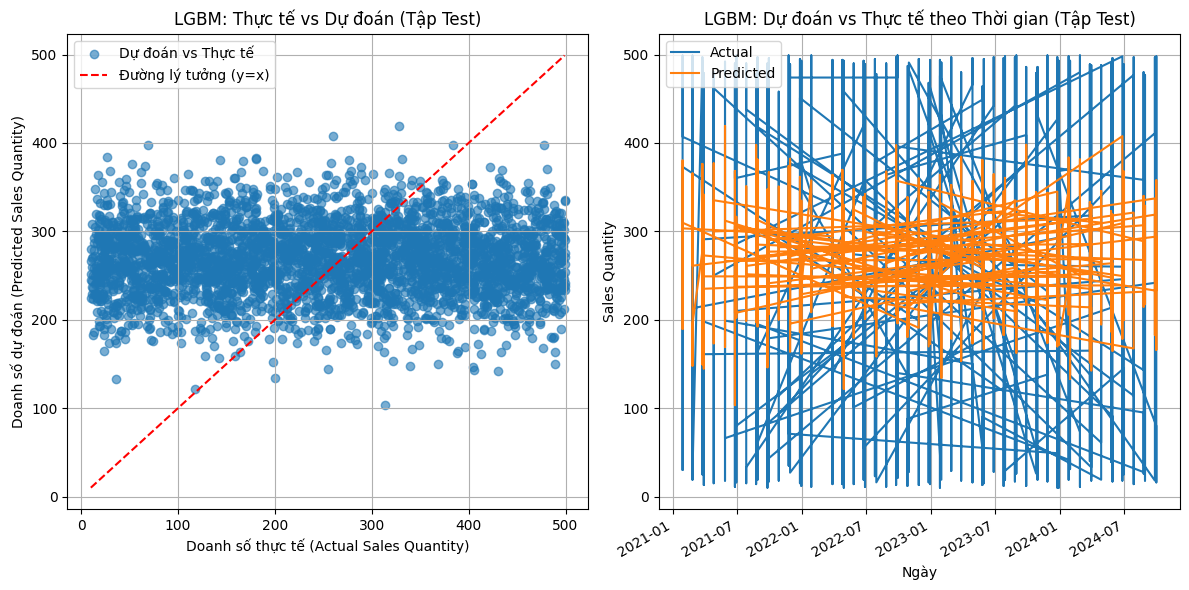

In [56]:
# --- Trực quan hóa kết quả dự đoán LightGBM trên tập Test ---
plt.figure(figsize=(12, 6))

# Biểu đồ so sánh giá trị thực tế và dự đoán
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test_lgbm, alpha=0.6, label='Dự đoán vs Thực tế')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', label='Đường lý tưởng (y=x)')
plt.xlabel("Doanh số thực tế (Actual Sales Quantity)")
plt.ylabel("Doanh số dự đoán (Predicted Sales Quantity)")
plt.title("LGBM: Thực tế vs Dự đoán (Tập Test)")
plt.legend()
plt.grid(True)

# Biểu đồ time series của giá trị thực tế và dự đoán
plt.subplot(1, 2, 2)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test_lgbm})
results_df = results_df.set_index(df_lgbm.iloc[split_index:]['Date']) # Lấy index thời gian
results_df.plot(figsize=(12,6), ax=plt.gca()) # Vẽ trên trục hiện tại
plt.title('LGBM: Dự đoán vs Thực tế theo Thời gian (Tập Test)')
plt.xlabel('Ngày')
plt.ylabel('Sales Quantity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

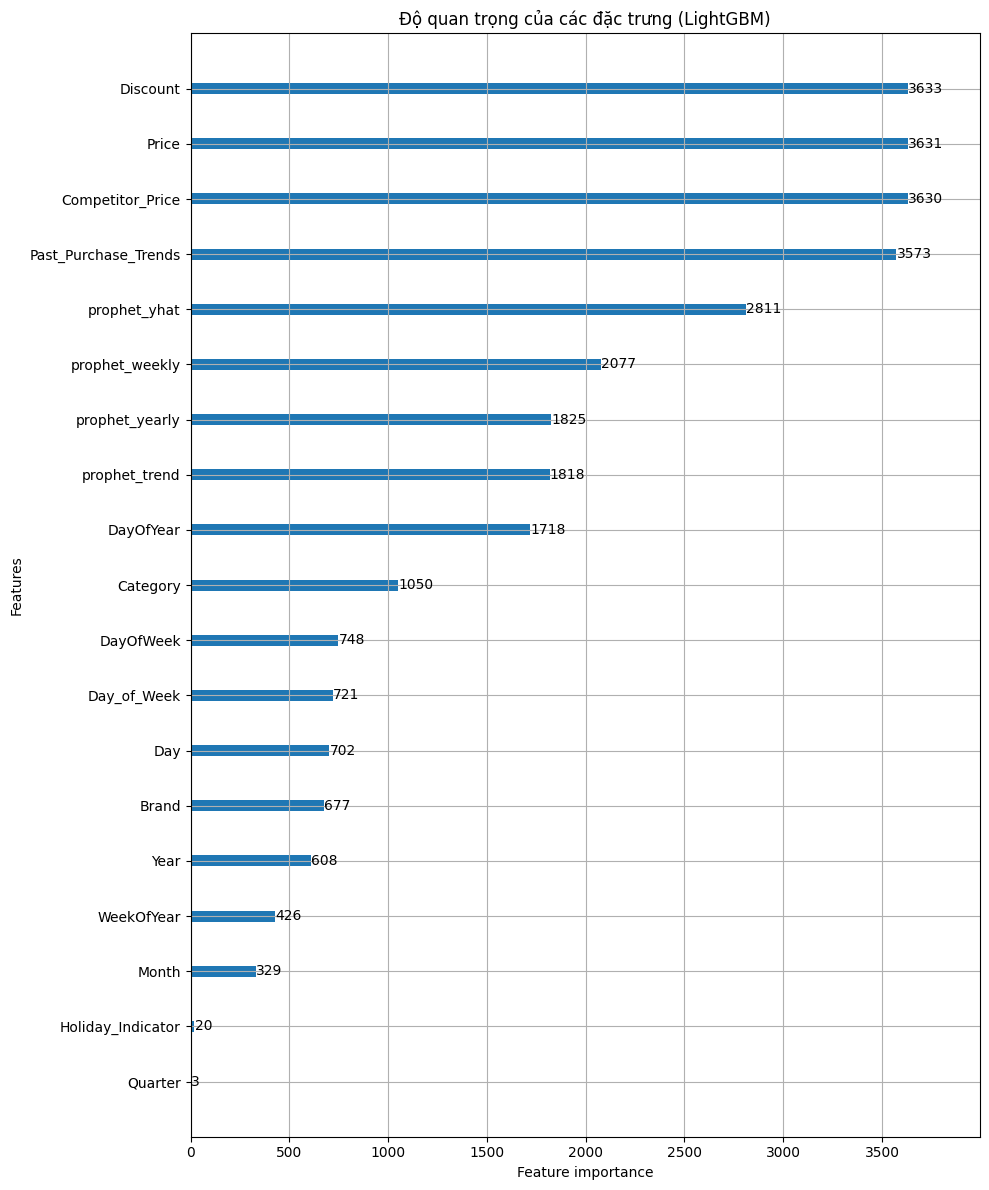


--- Kết luận và Hướng phát triển ---
Mô hình kết hợp Prophet và LightGBM cho kết quả R² là -0.09 trên tập kiểm tra.
Việc kết hợp Prophet giúp đưa thông tin về xu hướng/mùa vụ vào LGBM, có thể cải thiện độ chính xác so với hồi quy tuyến tính đơn giản.

Các bước tiếp theo có thể bao gồm:
1. Tinh chỉnh siêu tham số (Hyperparameter Tuning) cho cả Prophet và LightGBM (ví dụ: dùng GridSearchCV, RandomizedSearchCV, Optuna).
2. Kỹ thuật đặc trưng (Feature Engineering) nâng cao hơn: tạo biến trễ (lag features) cho Sales_Quantity và các biến khác, rolling statistics (trung bình trượt,...), tương tác phức tạp giữa các biến.
3. Thử nghiệm các mô hình học máy khác như XGBoost hoặc CatBoost (CatBoost xử lý biến phân loại tự động tốt hơn).
4. Đánh giá kỹ hơn các thành phần của Prophet và cách chúng đóng góp vào mô hình LGBM.
5. Phân tích lỗi (Error Analysis): Xem xét các trường hợp mô hình dự đoán sai nhiều để hiểu rõ hơn hạn chế.
6. Sử dụng Cross-Validation phù hợp với chuỗi thời gian (ví dụ: TimeS

In [57]:
# --- Hiển thị độ quan trọng của các đặc trưng ---
try:
    lgb.plot_importance(lgbm_model, figsize=(10, 12), max_num_features=30) # Giới hạn 30 features quan trọng nhất
    plt.title('Độ quan trọng của các đặc trưng (LightGBM)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"\nKhông thể vẽ biểu đồ độ quan trọng: {e}")

# --- Kết luận và Hướng phát triển ---
print("\n--- Kết luận và Hướng phát triển ---")
print(f"Mô hình kết hợp Prophet và LightGBM cho kết quả R² là {r2_test_lgbm:.2f} trên tập kiểm tra.")
print("Việc kết hợp Prophet giúp đưa thông tin về xu hướng/mùa vụ vào LGBM, có thể cải thiện độ chính xác so với hồi quy tuyến tính đơn giản.")
print("\nCác bước tiếp theo có thể bao gồm:")
print("1. Tinh chỉnh siêu tham số (Hyperparameter Tuning) cho cả Prophet và LightGBM (ví dụ: dùng GridSearchCV, RandomizedSearchCV, Optuna).")
print("2. Kỹ thuật đặc trưng (Feature Engineering) nâng cao hơn: tạo biến trễ (lag features) cho Sales_Quantity và các biến khác, rolling statistics (trung bình trượt,...), tương tác phức tạp giữa các biến.")
print("3. Thử nghiệm các mô hình học máy khác như XGBoost hoặc CatBoost (CatBoost xử lý biến phân loại tự động tốt hơn).")
print("4. Đánh giá kỹ hơn các thành phần của Prophet và cách chúng đóng góp vào mô hình LGBM.")
print("5. Phân tích lỗi (Error Analysis): Xem xét các trường hợp mô hình dự đoán sai nhiều để hiểu rõ hơn hạn chế.")
print("6. Sử dụng Cross-Validation phù hợp với chuỗi thời gian (ví dụ: TimeSeriesSplit từ scikit-learn).")